# Predicting Heart Disease

The goal of this project is to use a dataset from the UCI Machine Learning Repository to determine factors which predict whether a person will have heart disease in the future. Potential predictor variables in the dataset include: Age, Sex, ChestPainType, RestingBP, Cholestoreol, FastingBS, RestingECG and more.  We will use machine learning in particular KNN models to predict these outcomes

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

# importing libraries

In [2]:
heart_data = pd.read_csv("heart_disease_prediction.csv")

### Data Profiling

In [3]:
heart_data.head()

# reviewing the data

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [4]:
print(heart_data.shape)

# total observations and columns

(918, 12)


In [5]:
heart_data.info()

# reviewing data types as categorical will need to be converted

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [6]:
heart_data.describe()

# reviewing the distribution of the data

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


After reviewing the data, the mean age of PN catpured is 53 so the sample population is not based on young folks.  No values are missing and based on the decsriptive statistics, but there are some potential issues to note. RestingBP, Cholesterol have a min of 0 which is not possible. 

### Plotting Categorical Variables

In [7]:
cat_variables = list(heart_data.dtypes[heart_data.dtypes == object].index)
cat_variables.extend(["FastingBS", "HeartDisease"])

# creating a list of categorical variables

In [8]:
cat_variables

['Sex',
 'ChestPainType',
 'RestingECG',
 'ExerciseAngina',
 'ST_Slope',
 'FastingBS',
 'HeartDisease']

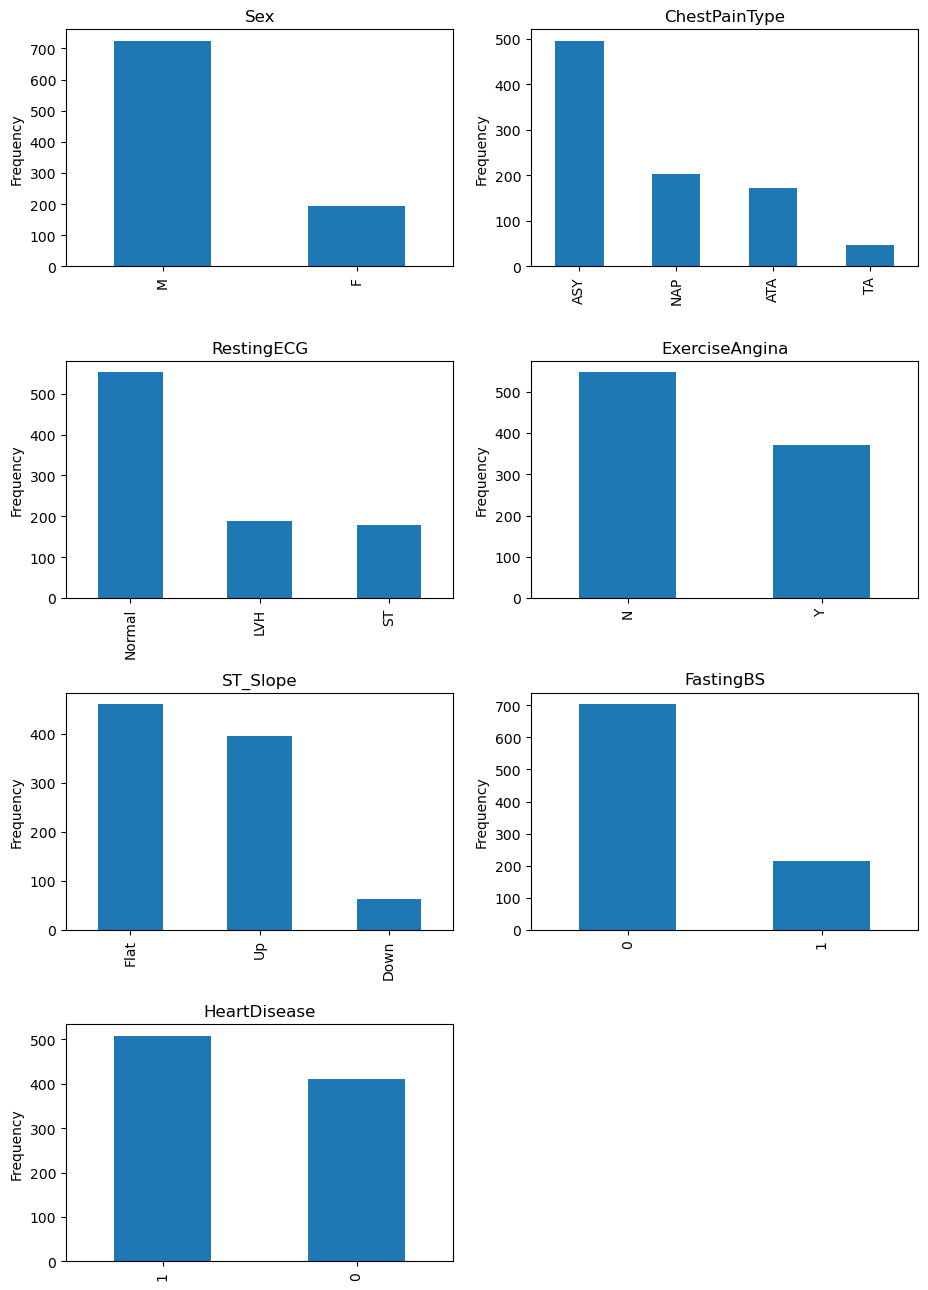

In [9]:
plt.figure(figsize=(11,16))
plot_count = 1

for var in cat_variables:
    plt.subplot(4,2,plot_count)
    heart_data[var].value_counts().plot.bar()
    plt.title(var)
    plt.ylabel("Frequency")
    plot_count += 1
    plt.subplots_adjust(hspace = .4)   

plt.show()

# plotting categorical variables counts with a loop

Based on the charts above there are some cateogrical variable which could impact our models.  The dataset is primarily male, has an ASY ChestPainType much more than others and most people surveyed were not fasting are the most notable.

### Data Cleaning

In [10]:
print("Resting BP blanks = ")
print(len(heart_data[heart_data["RestingBP"]==0]))

print("Cholesterol blanks = ")
print(len(heart_data[heart_data["Cholesterol"]==0]))

# confirming number of rows with 0.  Looks like we will remove BP and impute the median for cholesterol

Resting BP blanks = 
1
Cholesterol blanks = 
172


In [11]:
heart_data_clean = heart_data.copy()
print(len(heart_data_clean))

heart_data_clean = heart_data_clean[heart_data_clean["RestingBP"] != 0]
print(len(heart_data_clean))

# copies the DF and removes restingBP value of 0

918
917


In [12]:
heart_without_choloesterol = heart_data_clean[heart_data_clean["Cholesterol"] != 0]
Cholesterol_median = heart_without_choloesterol["Cholesterol"].median()
Cholesterol_median

# removes missing cholesterol rows and determines median to replace in the inital DF

237.0

In [13]:
cholest_zero_indices = heart_data_clean[heart_data_clean["Cholesterol"] == 0]["Cholesterol"].index

# pulling indices to replace values in the DF with 0

In [14]:
heart_data_clean.loc[cholest_zero_indices, "Cholesterol"] = 237

# updates cholesterol values of 0 to the median
# could take a more complicated approach and look at cholesterol values within other groups and replace accordingly for exmaple finding the median per patient who is male vs female or has heart disease

In [15]:
heart_data_clean.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,917.000000,917.000000,917.000000,917.000000,917.000000,917.000000,917.000000
mean,53.509269,132.540894,243.211559,0.233370,136.789531,0.886696,0.552890
std,9.437636,17.999749,53.430044,0.423206,25.467129,1.066960,0.497466
min,28.000000,80.000000,85.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,214.000000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,237.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


### Feature Selection

In [16]:
heart_data_clean = pd.get_dummies(heart_data_clean, drop_first=True)
heart_data_clean.head()

# creating dummy columns for categorical variables

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0.0,0,1,1,0,0,1,0,0,0,1
1,49,160,180,0,156,1.0,1,0,0,1,0,1,0,0,1,0
2,37,130,283,0,98,0.0,0,1,1,0,0,0,1,0,0,1
3,48,138,214,0,108,1.5,1,0,0,0,0,1,0,1,1,0
4,54,150,195,0,122,0.0,0,1,0,1,0,1,0,0,0,1


<AxesSubplot:>

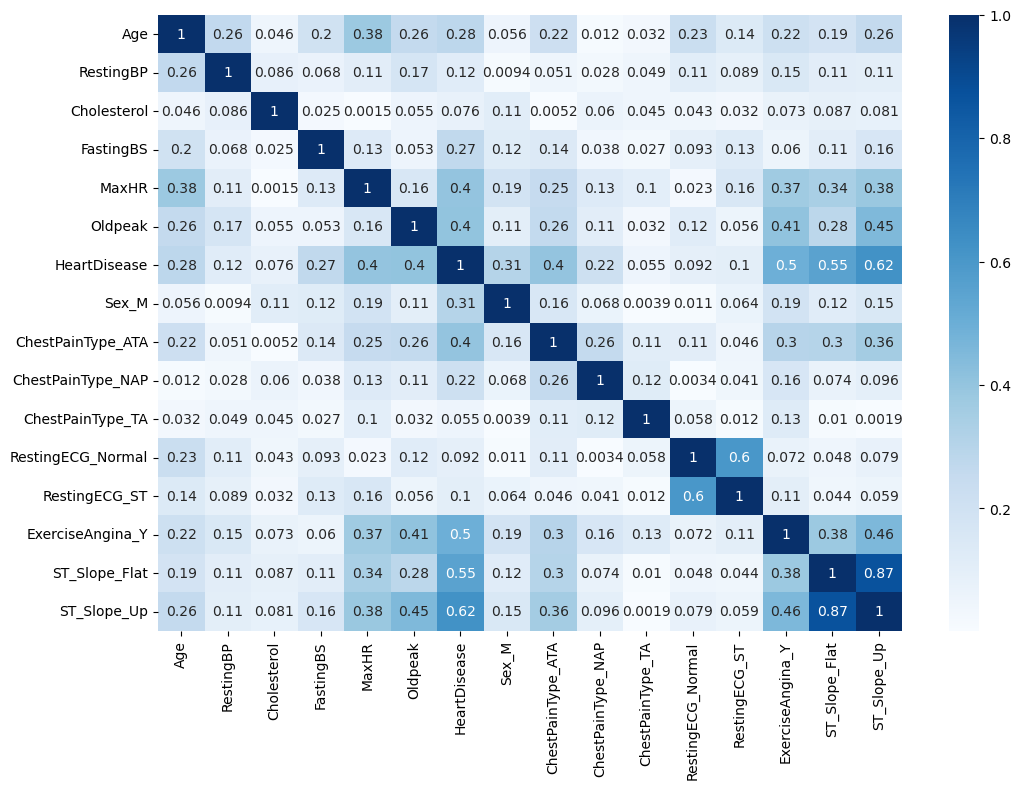

In [17]:
correlations = abs(heart_data_clean.corr())
plt.figure(figsize=(12,8))
sns.heatmap(correlations, annot=True, cmap="Blues")

# creating a heatmap to observe strong linear correlations between variables and heart disease

In [18]:
features = correlations[correlations["HeartDisease"] > .3].index

# creating a features list with a linear correlation > .3

In [19]:
heart_data_machine = heart_data_clean[features]

# creating DF with only features of interest

### Model Utilizing one Feature

In [20]:
X = heart_data_machine.drop("HeartDisease", axis = 1)
y = heart_data_machine["HeartDisease"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state = 417)

# splitting features columns with correlation > .3 and target column

In [21]:
features = features.drop("HeartDisease")

# removing heart disease from features as there was an error when ran with model below

In [22]:
for feature in features:
    knn = KNeighborsClassifier(n_neighbors = 3)
    knn.fit(X_train[[feature]], y_train)
    accuracy = knn.score(X_val[[feature]], y_val)
    print(f"The k-NN classifier trained on {feature} and with k = 3 has an accuracy of {accuracy*100:.2f}%")
    
# loop to run KNN model and display accuracy for each individual feature 

The k-NN classifier trained on MaxHR and with k = 3 has an accuracy of 54.89%
The k-NN classifier trained on Oldpeak and with k = 3 has an accuracy of 70.65%
The k-NN classifier trained on Sex_M and with k = 3 has an accuracy of 55.98%
The k-NN classifier trained on ChestPainType_ATA and with k = 3 has an accuracy of 44.02%
The k-NN classifier trained on ExerciseAngina_Y and with k = 3 has an accuracy of 71.20%
The k-NN classifier trained on ST_Slope_Flat and with k = 3 has an accuracy of 78.26%
The k-NN classifier trained on ST_Slope_Up and with k = 3 has an accuracy of 80.98%


In [23]:
correlations["HeartDisease"].sort_values()

ChestPainType_TA     0.054591
Cholesterol          0.076262
RestingECG_Normal    0.092452
RestingECG_ST        0.103067
RestingBP            0.117990
ChestPainType_NAP    0.215311
FastingBS            0.267994
Age                  0.282012
Sex_M                0.305118
MaxHR                0.401410
ChestPainType_ATA    0.401680
Oldpeak              0.403638
ExerciseAngina_Y     0.495490
ST_Slope_Flat        0.553700
ST_Slope_Up          0.621843
HeartDisease         1.000000
Name: HeartDisease, dtype: float64

Per the models ran above, it appears Oldpeak, ExerciseAngina_Y, ST_Slope_Flat and ST_Slope_Up all have high accuracy above 70%.  All these variables had high linear correlations. One interesting thing to note MaxHR (54%) and ChestPainType_ATA (44%) had a .4 linear correlation like Oldpeak however Oldpeak performed much better in the model (70%)

### Model Utilizing all Features

In [24]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Running normalization on the training values

In [25]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train_scaled, y_train)
accuracy = knn.score(X_val_scaled, y_val)
print(f"Accuracy: {accuracy*100:.2f} %")

# Running model with normalized/scaled values and printing accuracy

Accuracy: 82.61 %


The model utilizing all features with a > .3 correlation performed better than any single variable. ST_SlopeUp was close to utilizing all features but not the best.

### Hyperparameter Optimization

In [26]:
grid_params = {"n_neighbors": range(1, 20),
                "metric": ["minkowski", "manhattan"]
              }

knn = KNeighborsClassifier()
knn_grid = GridSearchCV(knn, grid_params, scoring='accuracy')
knn_grid.fit(X_train_scaled, y_train)

# creates a grid to test multiple parameters for the best model

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'metric': ['minkowski', 'manhattan'],
                         'n_neighbors': range(1, 20)},
             scoring='accuracy')

In [27]:
knn_grid.best_score_*100, knn_grid.best_params_

# pulling the parameters with the best accuracy

(84.29876060013045, {'metric': 'minkowski', 'n_neighbors': 18})

The minkowski and 18 neighbors produced the highest accuracy at 84% which is a little higher than the previous model with all parameters scaled by 2%

### Test Set Evaluation

In [28]:
predictions = knn_grid.best_estimator_.predict(X_val_scaled)
accuracy = accuracy_score(predictions, y_val)
print(f" Model Accuracy on test set: {accuracy*100:.2f}")

# determines the models accuracy on the test set

 Model Accuracy on test set: 84.24


Based on the test results above, the accuracy was also 84% per the optimal parameters determined in the previous step (K = 18 and metrick = minowski). Although this model is fairly accurate, it may not capture the overall population accurately based on the sample data as seen in our frequency plots. For example, having significantly more males than females may skew our model and introduce bias if one has a higher or lower correlation with heart disease.